In [1]:
%pylab inline

import os, styles
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import L_sun

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mean_wl(passband):
    return trapz(passband[:,0] * passband[:,1], passband[:,0])/trapz(passband[:,1], passband[:,0])

In [3]:
fnames = ["data/total_file_z021.dat", "data/total_file_z050.dat", "data/total_file_z090.dat"]
mock_seds = [loadtxt(fname) for fname in fnames]
mock_reds = [eval(fname.split(".")[0].split("_")[-1].lstrip("z0"))*0.01 for fname in fnames]

used_filter_names = loadtxt("data/filters.dat", dtype=np.str, usecols=(1,))

filter_names = [file for root, subs, files in os.walk("filters") for file in files if file.endswith(".res")]
filter_names = [filter_names[j] for i in xrange(len(used_filter_names)) for j in xrange(len(filter_names)) if filter_names[j].startswith(used_filter_names[i])]

jpas_right_order = range(58) + [len(filter_names)-1]
jplus_right_order = range(58,len(filter_names)-1)

jpas_filters = array(filter_names)[jpas_right_order]
jplus_filters = array(filter_names)[jplus_right_order]

In [4]:
#COMPUTE THE MEAN WAVELENGTH
jpas_wl = array([mean_wl(loadtxt("filters/{}".format(fname))) for fname in jpas_filters])
jplus_wl = array([mean_wl(loadtxt("filters/{}".format(fname),usecols=(0,2))) for fname in jplus_filters])

#SORT BY WAVELENGTH
jpas_isort = argsort(jpas_wl)
jplus_isort = argsort(jplus_wl)

jpas_filters = array(jpas_filters)[jpas_isort]
jpas_wl = jpas_wl[jpas_isort]

jplus_filters = array(jplus_filters)[jplus_isort]
jplus_wl = jplus_wl[jplus_isort]

write_filter_files = True
if write_filter_files:
    jpas = open("filters/JPAS_filters.txt", "w")
    for filter_name in jpas_filters:
        jpas.write("# {}\n".format(filter_name.rstrip(".res")))
        savetxt(jpas, loadtxt("filters/{}".format(filter_name)))
    jpas.close()
    
    jplus = open("filters/JPLUS_filters.txt", "w")
    for filter_name in jplus_filters:
        jplus.write("# {}\n".format(filter_name.rstrip(".res")))
        savetxt(jplus, loadtxt("filters/{}".format(filter_name),usecols=(0,2)))
    jplus.close()

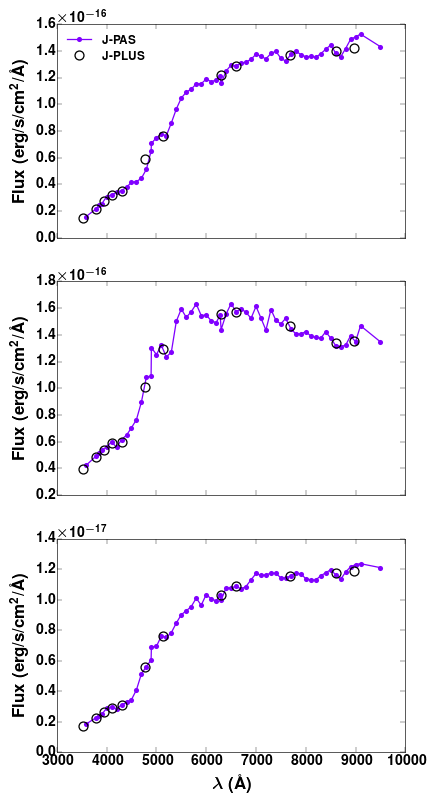

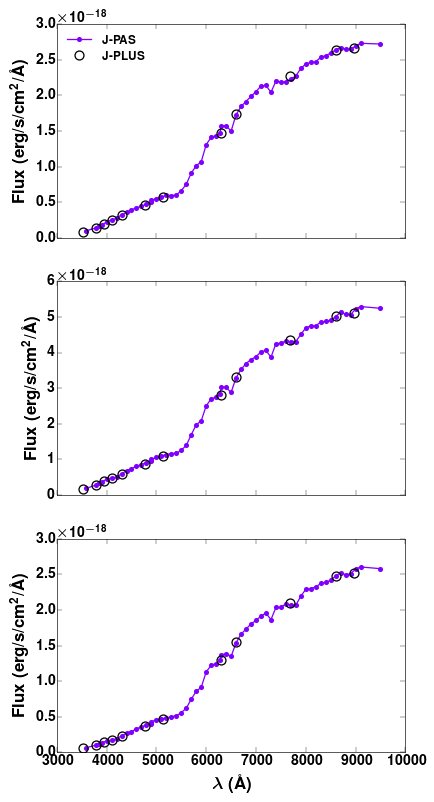

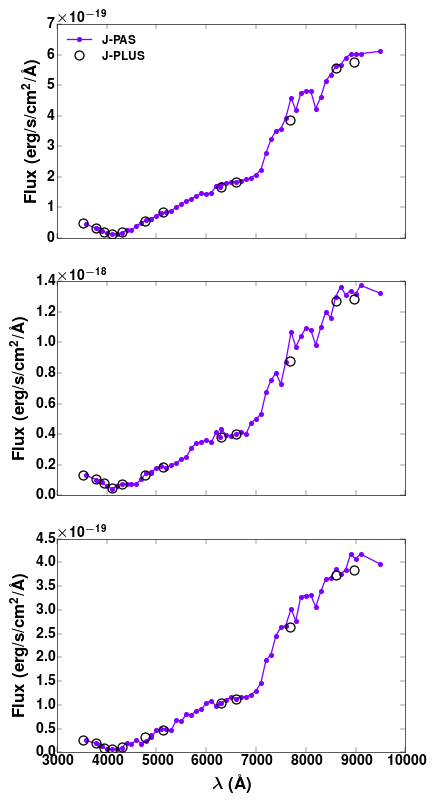

In [5]:
NPLOTS = 3
write_sed_files = True

#SPLIT SEDs DATA
for j in xrange(len(mock_reds)):
    jpas_fl = mock_seds[j][0::2,jpas_right_order][:,jpas_isort]
    jpas_sg = mock_seds[j][1::2,jpas_right_order][:,jpas_isort]
    jplus_fl = mock_seds[j][0::2,jplus_right_order][:,jplus_isort]
    jplus_sg = mock_seds[j][1::2,jplus_right_order][:,jplus_isort]
    
    NGAL = jpas_fl.shape[0]

    jpas_mask = ones(jpas_fl.shape[1], dtype=bool)
    jpas_mask = (jpas_fl>0.0)&(repeat([jpas_mask],NGAL,axis=0))

    jplus_mask = ones(jplus_fl.shape[1], dtype=bool)
    jplus_mask = (jplus_fl>0.0)&(repeat([jplus_mask],NGAL,axis=0))

    distances = FlatLambdaCDM(H0=70, Om0=0.3).luminosity_distance(mock_reds[j]).cgs.value
    d_correction = 4*pi*distances*(distances/L_sun.cgs.value)

    fig, axs = subplots(NPLOTS, 1, sharex=True, figsize=(5,NPLOTS*3))
    for i in range(NPLOTS):
        axs[i].plot(jpas_wl[jpas_mask[i]], jpas_fl[i][jpas_mask[i]], "-o", ms=4, mew=0, label=r"\bf J-PAS")
        axs[i].plot(jplus_wl[jplus_mask[i]], jplus_fl[i][jplus_mask[i]], "o", mfc="none", ms=7, mew=1, label=r"\bf J-PLUS")

        axs[i].set_ylabel(r"\bf Flux (erg/s/cm${}^{2}$/\AA)")

    axs[0].legend(loc=0)
    axs[i].set_xlabel(r"\bf $\lambda$ (\AA)")
    axs[i].set_xlim(3000,10000)
    fig.tight_layout()
    #fig.savefig("SDSS_sample.png", bbox_inches="tight")
    
    #WRITE SEDs
    if write_sed_files:
        jpas_fl[~jpas_mask] = 0.0
        jpas_sg[~jpas_mask] = 0.0
        jplus_fl[~jplus_mask] = 0.0
        jplus_sg[~jplus_mask] = 0.0

        fmt = "%8.3f%12.4e%12.4e"
        hdr = "%6s%12s%12s"%tuple("weff flux error".split())
        for i in xrange(NGAL):
            jpas_table = column_stack((jpas_wl, jpas_fl[i]*d_correction, jpas_sg[i]*d_correction))
            jpas_file_sed = open("jpas-z{0}/jpas-z{0}_{1:04d}.txt".format("{0:3.2f}".format(mock_reds[j]).replace(".", "p"), i+1), "w")
            jpas_file_sed.write("# redshift = {0:4.2f}\n".format(mock_reds[j]))
            jpas_file_sed.write("#\n")
            savetxt(jpas_file_sed, jpas_table, fmt=fmt, header=hdr)
            jpas_file_sed.close()

            jplus_table = column_stack((jplus_wl, jplus_fl[i]*d_correction, jplus_sg[i]*d_correction))
            jplus_file_sed = open("jplus-z{0}/jplus-z{0}_{1:04d}.txt".format("{0:3.2f}".format(mock_reds[j]).replace(".", "p"), i+1), "w")
            jplus_file_sed.write("# redshift = {0:4.2f}\n".format(mock_reds[j]))
            jplus_file_sed.write("#\n")
            savetxt(jplus_file_sed, jplus_table, fmt=fmt, header=hdr)
            jplus_file_sed.close()